In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

curr_dir = pathlib.Path(".")

In [40]:
# Read in historical load data (July 9, 2024)
df_load = pd.read_csv(curr_dir / "data" / "CAISO-netdemand-20240709.csv", index_col=[0]).T.iloc[0:-1]
df_gen = pd.read_csv(curr_dir / "data" / "CAISO-supply-20240709.csv", index_col=[0]).T.iloc[0:-1]
df_ren = pd.read_csv(curr_dir / "data" / "CAISO-renewables-20240709.csv", index_col=[0]).T

In [41]:
# Clean up index
new_index = pd.date_range(start="2024-07-09 00:00", end="2024-07-10 00:00", periods=289)[0:-1]

df_load.index = new_index
df_load.index.name = "timestamp"
df_load.columns.name = None

df_gen.index = new_index
df_gen.index.name = "timestamp"
df_gen.columns.name = None

df_ren.index = new_index
df_ren.index.name = "timestamp"
df_ren.columns.name = None

In [48]:
# Assert that sum of renewable generation is consistent in df_ren and df_gen
assert (df_ren.sum(axis=1) == df_gen["Renewables"]).all()

In [154]:
# Combine data into a single data frame
df_data = pd.concat([df_load[["Demand", "Net demand"]], df_gen[["Natural gas", "Large hydro", "Batteries", "Nuclear", "Imports"]], df_ren], axis=1)

# Re-sample to hourly frequency
df_data = df_data.resample("1h").asfreq()

# Combine hydro
df_data["Hydro"] = df_data[["Large hydro", "Small hydro"]].sum(axis=1)

# Combine biomass
df_data["Biomass"] += df_data["Biogas"]

# Dispatch order
dispatch_order = ["Nuclear", "Hydro", "Natural gas", "Geothermal", "Biomass", "Solar", "Wind", "Batteries", "Imports"]

# True up demand for exports and battery charging
df_data["Demand + Charging + Exports"] = df_data["Demand"] - df_data[["Batteries", "Imports"]].clip(upper=0).sum(axis=1)
df_data[["Batteries", "Imports"]] = df_data[["Batteries", "Imports"]].clip(lower=0)

# True up imports with demand (account for small discrepancies / losses)
df_data["Imports"] += df_data["Demand + Charging + Exports"] - df_data[dispatch_order].sum(axis=1)

# Get final data
df_data = df_data[["Demand", "Demand + Charging + Exports"] + dispatch_order]

In [185]:
# Create a cool stack plot of generation
color_map = {
    "Nuclear": "blanchedalmond",
    "Hydro": "steelblue",
    "Natural gas": "lightgray",
    "Geothermal": "salmon",
    "Biomass": "lightgreen",
    "Solar": "gold",
    "Wind": "lightskyblue",
    "Batteries": "slateblue",
    "Imports": "whitesmoke",
}

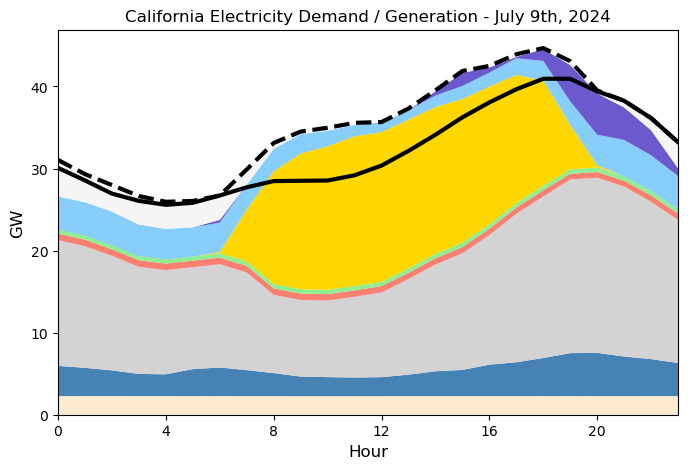

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches((8, 5))

ax.plot(df_data.index, df_data["Demand"], color="black", linewidth=3.0, label="Load")
ax.plot(df_data.index, df_data["Demand + Charging + Exports"], color="black", linestyle="dashed", linewidth=3.0, label="Load + Exports + Charging")
ax.stackplot(df_data.index, df_data[dispatch_order].values.T, colors=color_map.values())
ax.axis([min(df_data.index), max(df_data.index), None, None])

ax.set_xticks(df_data.index[::4], df_data.index.hour[::4], fontsize=10)
ax.set_yticks([0, 10000, 20000, 30000, 40000], [0, 10, 20, 30, 40], fontsize=10)

plt.title(f"California Electricity Demand / Generation - July 9th, 2024", fontsize=12)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("GW", fontsize=12)
plt.show()

In [187]:
# Save dataframe
df_data.to_csv(curr_dir / "data" / "load_and_generation_data.csv")

In [ ]:
# Read in nameplate capacity
df_nameplate = pd.read_csv(curr_dir / "data" / "nameplate_capacity_by_type.csv", index_col=[0])
df_nameplate.loc["Solar"] -= 17100 # Nameplate capacity of behind-the-meter solar

In [ ]:
# Cost and emissions information
df_build = pd.DataFrame()
df_build["Solar"] = 